In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path ='/content/drive/My Drive/tweet_emotions.csv'
df = pd.read_csv(file_path)

In [ ]:
# İlk birkaç satırı görüntüleyin
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
df.shape[0]

40000

In [ ]:
# Veri setinin yapısını görüntüleyin
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [ ]:
# Duygu dağılımını inceleyin
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [ ]:
df = df[(df['sentiment'] != 'anger') & (df['sentiment'] != 'boredom') & (df['sentiment'] != 'enthusiasm')& (df['sentiment'] != 'empty')& (df['sentiment'] != 'relief')& (df['sentiment'] != 'fun')& (df['sentiment'] != 'love')]
df.shape[0]

30981

In [ ]:
df['sentiment'].value_counts()

sentiment
neutral      8638
worry        8459
happiness    5209
sadness      5165
surprise     2187
hate         1323
Name: count, dtype: int64

In [ ]:
# Eksik verileri kontrol edin
print(df.isnull().sum())

tweet_id     0
sentiment    0
content      0
dtype: int64


In [ ]:
# Tekrarlanan satırları kontrol edin
print(df.duplicated().sum())

0


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Özel karakterleri ve sayıları kaldır
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    # Noktalama işaretlerini kaldır
    text = re.sub(r'[^\w\s]', '', text)
    # Durak kelimeleri kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Metin verisini temizleyin
df['content'] = df['content'].apply(clean_text)

In [ ]:
df.head()

,tweet_id,sentiment,content
1,1956967666,sadness,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,funeral ceremonygloomy friday
4,1956968416,neutral,want trade someone houston tickets one
5,1956968477,worry,repinging didnt go prom bc bf didnt like friends
6,1956968487,sadness,sleep im thinking old friend want hes married ...


In [ ]:
# Duygu etiketlerini sayısal değerlere dönüştür
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
# Eğitim ve test veri setlerini ayır
X = df['content'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [ ]:
# Metin verilerini sayısal değerlere dönüştür
max_words = 3000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Etiketleri one-hot encode
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          384000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 433798 (1.65 MB)
Trainable params: 433798 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=1000, validation_split=0.2)

Epoch 1/15
20/20 [==============================] - 49s 2s/step - loss: 1.6874 - accuracy: 0.2750 - val_loss: 1.6206 - val_accuracy: 0.3143
Epoch 2/15
20/20 [==============================] - 42s 2s/step - loss: 1.6073 - accuracy: 0.3338 - val_loss: 1.5924 - val_accuracy: 0.3286
Epoch 3/15
20/20 [==============================] - 39s 2s/step - loss: 1.5631 - accuracy: 0.3516 - val_loss: 1.5491 - val_accuracy: 0.3688
Epoch 4/15
20/20 [==============================] - 45s 2s/step - loss: 1.4839 - accuracy: 0.4078 - val_loss: 1.4881 - val_accuracy: 0.4015
Epoch 5/15
20/20 [==============================] - 44s 2s/step - loss: 1.3886 - accuracy: 0.4571 - val_loss: 1.4667 - val_accuracy: 0.4132
Epoch 6/15
20/20 [==============================] - 41s 2s/step - loss: 1.3221 - accuracy: 0.4905 - val_loss: 1.4597 - val_accuracy: 0.4230
Epoch 7/15
20/20 [==============================] - 43s 2s/step - loss: 1.2683 - accuracy: 0.5084 - val_loss: 1.4764 - val_accuracy: 0.4202
Epoch 8/15
20/20 [==

In [ ]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

194/194 [==============================] - 6s 29ms/step - loss: 1.6599 - accuracy: 0.3891
Test Accuracy: 38.91%


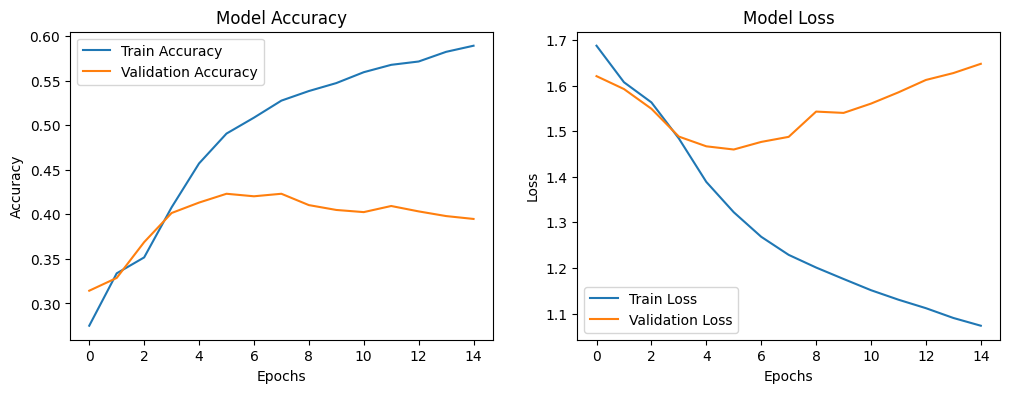

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
# Modeli kaydedin
model.save('/content/drive/My Drive/LSTM/lstm_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "the weather is very nice today"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 51ms/step
neutral


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "My stomach hurts"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 178ms/step
worry


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "Happy Mothers Day mummy"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 60ms/step
happiness


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "My mom died"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 34ms/step
sadness


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "I can't believe it!"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 36ms/step
surprise


In [ ]:
# Örnek bir metin üzerinde modeli kullanma
text = "I'm very angry right now!"
text_seq = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_seq, maxlen=max_len)
prediction = model.predict(text_pad)
# Duygu etiketini alın
predicted_label = np.argmax(prediction, axis=-1)

# Sayısal değeri etiket adına dönüştürme
predicted_sentiment = label_encoder.inverse_transform(predicted_label)[0]
print(predicted_sentiment)

1/1 [==============================] - 0s 77ms/step
hate
